<a href="https://colab.research.google.com/github/rupaai/caffeine_coders_emotion_recognition/blob/master/emotion_ecognition_with_federated_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F

#torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [0]:
import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

In [3]:
!pip install tf-encrypted

! URL="https://github.com/openmined/PySyft.git" && FOLDER="PySyft" && if [ ! -d $FOLDER ]; then git clone -b dev --single-branch $URL; else (cd $FOLDER && git pull $URL && cd ..); fi;

!cd PySyft; python setup.py install  > /dev/null

import os
import sys
module_path = os.path.abspath(os.path.join('./PySyft'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
!pip install --upgrade --force-reinstall lz4
!pip install --upgrade --force-reinstall websocket
!pip install --upgrade --force-reinstall websockets
!pip install --upgrade --force-reinstall zstd

From https://github.com/openmined/PySyft
 * branch              HEAD       -> FETCH_HEAD
Already up to date.
zip_safe flag not set; analyzing archive contents...
  Using cached https://files.pythonhosted.org/packages/0a/c6/96bbb3525a63ebc53ea700cc7d37ab9045542d33b4d262d0f0408ad9bbf2/lz4-2.1.10-cp36-cp36m-manylinux1_x86_64.whl
ERROR: syft 0.1.23a1 has requirement msgpack>=0.6.1, but you'll have msgpack 0.5.6 which is incompatible.
  Found existing installation: lz4 2.1.10
    Uninstalling lz4-2.1.10:
      Successfully uninstalled lz4-2.1.10


  Using cached https://files.pythonhosted.org/packages/bf/45/142141aa47e01a5779f0fa5a53b81f8379ce8f2b1cd13df7d2f1d751ae42/greenlet-0.4.15-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f2/ca/5b5962361ed832847b6b2f9a2d0452c8c2f29a93baef850bb8ad067c7bf9/gevent-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: greenlet 0.4.15
    Uninstalling greenlet-0.4.15:
      Successfully uninstalled greenlet-0.4.15
  Found existing installation: gevent 1.4.0
    Uninstalling gevent-1.4.0:
      Successfully uninstalled gevent-1.4.0
  Found existing installation: websocket 0.2.1
    Uninstalling websocket-0.2.1:
      Successfully uninstalled websocket-0.2.1
  Using cached https://files.pythonhosted.org/packages/f0/4b/ad228451b1c071c5c52616b7d4298ebcfcac5ae8515ede959db19e4cd56d/websockets-8.0.2-cp36-cp36m-manylinux1_x86_64.whl
ERROR: syft 0.1.23a1 has requirement msgpack>=0.6.1, but you'll have msgpack 0.5.6 which is incompatible.
  Found 

In [4]:
import syft as sy
hook = sy.TorchHook(torch)

# Create a couple of workers
bob = sy.VirtualWorker(hook, id="bob")  
alice = sy.VirtualWorker(hook, id="alice")

W0820 19:52:14.407905 139985039218560 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0820 19:52:14.427928 139985039218560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
import pickle

def covert_into_pickle(item, directory):
    pickle.dump(item, open(directory,'wb'))

def load_from_pickle(directory):
    return pickle.load(open(directory,'rb'))

In [6]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


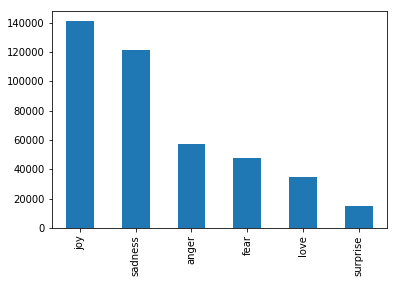

In [7]:
#load data
data = load_from_pickle(directory='/gdrive/My Drive/Resources/Dataset/emotion-detection/merged_training.pkl')
data.emotions.value_counts().plot.bar()

In [8]:
print(data.shape)
print(type(data))

(416809, 2)
<class 'pandas.core.frame.DataFrame'>


In [9]:
data.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [0]:
#copying data with number of tokens less than 70
data["token size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data["token size"] < 70].copy()

#sampling data
data = data.sample(n=50000, replace=True)

In [0]:
from nltk import word_tokenize

#import nltk
#nltk.download('punkt')

In [0]:
class ConstructDictionary():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2index = {}
        self.index2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        
        #creating tokens from sentences and adding them to dictionary
        for sentence in self.sentences:
            self.vocab.update(word_tokenize(sentence))
            
        #sorting the dictionary
        self.vocab = sorted(self.vocab)
        
        #adding padding token to 0 index
        self.word2index['<pad>'] = 0
           
        #creating a word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2index[word] = index + 1         #adding 1 becuase of padding element at 0 index
            
        #creating a index to word mapping
        for index, word in self.word2index.items():
            self.index2word[index] = word

In [13]:
inputs = ConstructDictionary(data["text"].values.tolist())
inputs.vocab[:10]

['a',
 'aa',
 'aaa',
 'aaaaall',
 'aactually',
 'aad',
 'aaishwaryaa',
 'aakash',
 'aardvarkartglass',
 'aaron']

In [14]:
len(inputs.vocab)

26591

In [15]:
input_tensors = [[inputs.word2index[word] for word in word_tokenize(sentence) ] for sentence in data['text'].values.tolist() ]
input_tensors[:2]

[[11378,
  8598,
  25779,
  1,
  11210,
  17426,
  14363,
  21304,
  13174,
  11409,
  17413,
  9917,
  3244,
  26582,
  4191,
  17413,
  9917,
  3244,
  22075,
  26582,
  10192,
  16341,
  23587],
 [11378, 9123, 16344, 10379, 2071, 7060, 4899, 871, 25613, 8608, 17653, 7316]]

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [17]:
max_length_input = max_length(input_tensors)
print(max_length_input)

69


In [0]:
def pad_sequences(x, max_len=max_length_input):
    padded = np.zeros((max_len), dtype=np.int64)
    padded[:len(x)] = x
    return padded

In [19]:
input_tensors = [pad_sequences(x, max_length_input) for x in input_tensors]
input_tensors[:2]

[array([11378,  8598, 25779,     1, 11210, 17426, 14363, 21304, 13174,
        11409, 17413,  9917,  3244, 26582,  4191, 17413,  9917,  3244,
        22075, 26582, 10192, 16341, 23587,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([11378,  9123, 16344, 10379,  2071,  7060,  4899,   871, 25613,
         8608, 17653,  7316,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [0]:
#now we are using transforming our target values using one-hot encoding

emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)

mlb = preprocessing.MultiLabelBinarizer()

data_labels = [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [21]:
target_tensor[:2]

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [22]:
data[0:2]

,text,emotions,token size
75181,i feel welcomed a href photos martatom sizes l...,joy,23
77509,i for one had been drinking constantly and was...,joy,12


In [0]:
def get_emotion(x):
    return np.argmax(x)

In [24]:
get_emotion(target_tensor[0])

2

In [0]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [26]:
emotion_dict[get_emotion(target_tensor[0])]

'joy'

In [27]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensors, target_tensor, test_size=0.2)


# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

In [0]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2index)
target_size = num_emotions

In [0]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [0]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [0]:
train_dataset = sy.BaseDataset(input_tensor_train, target_tensor_train).federate((alice,bob))
val_dataset = sy.BaseDataset(input_tensor_val, target_tensor_val).federate((alice,bob))
test_dataset = sy.BaseDataset(input_tensor_test, target_tensor_test).federate((alice,bob))





federated_train_loader = sy.FederatedDataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
federated_val_loader = sy.FederatedDataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
federated_test_loader = sy.FederatedDataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [32]:
input, labels = next(iter(federated_train_loader))
print(input[0].get(), labels[0].get())

tensor([11378,  8598,  2782, 23844,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0]) tensor([1, 0, 0, 0, 0, 0])


In [0]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden

In [0]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(federated_train_loader)
x, y = next(it)

model.send(x.location)
x = x.transpose(0,1)
# sort the batch first to be able to use with pac_pack sequence
#xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", x.get().size())

output, _ = model(x.to(device), device)
model.get()
print(output.size())

Input size:  torch.Size([69, 64])


RuntimeError: ignored

In [0]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [38]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    batch = 1
    
    ### Training
    #model.train()
    
    for input, label in federated_train_loader:
        loss = 0
        print("i")
        #print(model.location)
        
        model = model.send(input.location)
        
        predictions, _ = model.forward(input.to(device), device) # TODO:don't need _   
              
        loss += loss_function(label.to(device), predictions).get()
        batch_loss = (loss / int(label.shape[1])).get()  
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(label.to(device), predictions).get()
        train_accuracy += batch_accuracy
        
        model = model.get()
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
        batch += 1
            
    ### Validating
    model.eval()
    with torch.no_grad():
      for input, label in federated_val_loader: 
          model = model.send(input.location)
          predictions,_ = model(input.permute(1, 0).to(device), device)        
          batch_accuracy = accuracy(label.to(device), predictions).get()
          val_accuracy += batch_accuracy
          model = model.get()
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
  
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} '.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             ))
  
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

i


IndexError: ignored

In [39]:
model.get()

EmoGRU(
  (embedding): Embedding(26592, 256)
  (dropout): Dropout(p=0.5)
  (gru): GRU(256, 1024)
  (fc): Linear(in_features=1024, out_features=6, bias=True)
)